In [24]:
import pandas as pd

sats = pd.read_csv(
        "catsat.csv",
        index_col="INTLDES"  # to use NSSDC ID as ID
    )
print("Loaded {} datas with {} features".format(sats.shape[0], sats.shape[1]))
sats.head()

Loaded 44015 datas with 23 features


NORAD_CAT_ID  OBJECT_TYPE       SATNAME COUNTRY      LAUNCH   SITE  \
INTLDES                                                                         
1957-001A             1  ROCKET BODY      SL-1 R/B     CIS  1957-10-04  TTMTR   
1957-001B             2      PAYLOAD     SPUTNIK 1     CIS  1957-10-04  TTMTR   
1957-002A             3      PAYLOAD     SPUTNIK 2     CIS  1957-11-03  TTMTR   
1958-001A             4      PAYLOAD    EXPLORER 1      US  1958-02-01  AFETR   
1958-002A            16  ROCKET BODY  VANGUARD R/B      US  1958-03-17  AFETR   

                DECAY  PERIOD  INCLINATION  APOGEE      ...       RCSVALUE  \
INTLDES                                                 ...                  
1957-001A  1957-12-01   96.19        65.10   938.0      ...              0   
1957-001B  1958-01-03   96.10        65.00   945.0      ...              0   
1957-002A  1958-04-14  103.74        65.33  1659.0      ...              0   
1958-001A  1970-03-31   88.48        33.15   215.0      ...              0   
1958-002A         NaN  137.31        34.28  4227.0      ...              0   

          RCS_SIZE  FILE  LAUNCH_YEAR LAUNCH_NUM  LAUNCH_PIECE  CURRENT  \
INTLDES                                                                   
1957-001A    LARGE     1         1957          1             A        Y   
1957-001B      NaN     1         1957          1             B        Y   
1957-002A    SMALL  5922         1957          2             A        Y   
1958-001A      NaN     1         1958          1             A        Y   
1958-002A   MEDIUM  6819         1958          2             A        Y   

            OBJECT_NAME  OBJECT_ID OBJECT_NUMBER  
INTLDES                                           
1957-001A      SL-1 R/B  1957-001A             1  
1957-001B     SPUTNIK 1  1957-001B             2  
1957-002A     SPUTNIK 2  1957-002A             3  
1958-001A    EXPLORER 1  1958-001A             4  
1958-002A  VANGUARD R/B  1958-002A            16  

[5 rows x 23 columns]

In [25]:
round(sats.describe(), 2)

NORAD_CAT_ID    PERIOD  INCLINATION     APOGEE    PERIGEE  COMMENTCODE  \
count      44015.00  42775.00     42775.00   42775.00   42775.00      2510.00   
mean       22008.00    191.51        70.29    4137.68    1944.40         3.65   
std        12706.19    704.01        25.25   14268.23    7020.99         1.44   
min            1.00      0.00         0.00       0.00       0.00         1.00   
25%        11004.50     89.12        58.69     261.00     186.00         3.00   
50%        22008.00     93.60        72.83     506.00     350.00         4.00   
75%        33011.50    103.05        97.19     998.00     765.00         5.00   
max        44016.00  95687.67       150.94  613535.00  265679.00         5.00   

       RCSVALUE      FILE  LAUNCH_YEAR  LAUNCH_NUM  OBJECT_NUMBER  
count   44015.0  44015.00     44015.00    44015.00       44015.00  
mean        0.0   4706.88      1987.75       48.23       22008.00  
std         0.0   2880.77        14.53       30.08       12706.19  
min         0.0      1.00      1957.00        0.00           1.00  
25%         0.0      1.00      1976.00       25.00       11004.50  
50%         0.0   5942.00      1987.00       43.00       22008.00  
75%         0.0   6814.00      1999.00       70.00       33011.50  
max         0.0   6819.00      2019.00      129.00       44016.00

# NASA 
We join with the NASA data:
* category 
* name
* precise launch date

In [26]:
import requests
import numpy as np
from bs4 import BeautifulSoup as soup
from tqdm import tqdm_notebook

In [27]:
# We add columns for the nasa data
sats["NASA_NAME"] = None
sats["NASA_LAUNCH"] = None
sats["NASA_CAT"] = None

# All the different categories available on the NASA website
cats = {
    "ASNO": "Astronomy",
    "ESNO": "Earth Science",
    "PSNO": "Planetary Science",
    "SONO": "Solar Physics",
    "SPNO": "Space Physics",
    "LSNO": "Life Science",
    "MGNO": "Microgravity",
    "HUNO": "Human Crew",
    "ENNO": "Engineering",
    "CONO": "Communications",
    "NANO": "Navigation/Global Positioning",
    "MLNO": "Surveillance and Other Military",
    "RENO": "Resupply/Refurbishment/Repair",
    "TANO": "Technology Applications",
    "UCNO": "Uncategorized Cosmos",
    "OTNO": "Other"
}

for cat in cats: #creating dummy variable for each category, since one sat can belong  to several
    sats["NASA_"+cat] = 0

In [28]:
catMili = "MLNO"
missing = {}
total, missed = 0, 0
for cat in tqdm_notebook(cats, desc="Categories"):
    missing[cat] = []
    r = requests.post('https://nssdc.gsfc.nasa.gov/nmc/spacecraft/query', data={"discipline": cat})
    s = soup(r.text, 'html.parser')
    for tr in tqdm_notebook(s.find_all('tr')[1:], desc=cats[cat]):  # 0 is the name of the columns
        tds = tr.find_all('td')
        name, sid, launch = tds[0].text, tds[1].text, tds[2].text
        if sid not in sats.index:
            missing[cat].append((name, sid, launch))
            missed += 1
        else:
            sats.loc[sid,["NASA_NAME", "NASA_LAUNCH", "NASA_"+cat, "NASA_CAT"]] = [None if name == '' else name.upper(), None if launch == '' else launch, 1, cat]
        total += 1
print("Processed {} satellites from NASA data. {} weren't in Space-track data".format(total, missed))


Processed 9715 satellites from NASA data. 754 weren't in Space-track data


In [29]:
# We display the missing satellites from the Space-track data
print("{} satellites in the NASA data but not in the space-track one:\n".format(missed))
for cat in missing:
    for name, sid, launch in missing[cat]:
        print("{:<40s} | {:^10s} |  {:10s}".format(name, sid, launch))

754 satellites in the NASA data but not in the space-track one:

AFP-675                                  |  AFP-675   |  1990-07-19
AFP-888                                  |  AFP-888   |  1990-07-19
Astro 1                                  |  ASTRO-1   |  1990-12-02
Astro 2                                  |  ASTRO-2   |  1995-03-02
Astromag FF                              |  ASTRMAG   |  2005-01-01
Atlas 1 / STS 45                         |   ATLAS1   |  1992-03-24
Beam                                     |    BEAM    |            
Challenger                               |  CHALNGR   |  1986-01-28
CORSA                                    |   CORSA    |  1976-02-06
COS-A                                    |   COS-A    |            
Discoverer  9                            |   DISC9    |  1960-02-04
Discoverer 16                            |   DISC16   |  1960-10-26
Discoverer 27                            |   DISC27   |  1961-07-22
Discoverer 28                            |   DISC28

In [30]:
sats[["NASA_NAME", "NASA_CAT", "NASA_LAUNCH"]].describe()

NASA_NAME NASA_CAT NASA_LAUNCH
count       7682     7682        7677
unique      7671       16        4832
top     SIRIUS 2     MLNO  2017-06-23
freq           2     2279          24

In [31]:
sats.iloc[18:23]

NORAD_CAT_ID  OBJECT_TYPE        SATNAME COUNTRY      LAUNCH  \
INTLDES                                                                   
1959-002A            13      PAYLOAD   DISCOVERER 1      US  1959-02-28   
1959-003A            14      PAYLOAD   DISCOVERER 2      US  1959-04-13   
1959-004A            15      PAYLOAD     EXPLORER 6      US  1959-08-07   
1959-004B            17  ROCKET BODY  THOR ABLE R/B      US  1959-08-07   
1959-005A            18      PAYLOAD   DISCOVERER 5      US  1959-08-13   

            SITE       DECAY  PERIOD  INCLINATION   APOGEE    ...     \
INTLDES                                                       ...      
1959-002A  AFWTR  1959-03-03   92.70        90.00    697.0    ...      
1959-003A  AFWTR  1959-04-26   90.40        89.90    346.0    ...      
1959-004A  AFETR  1961-06-30  762.25        46.95  42276.0    ...      
1959-004B  AFETR  1961-06-30  718.96        47.10  40215.0    ...      
1959-005A  AFWTR  1959-09-28   89.10        79.99    323.0    ...      

           NASA_MGNO NASA_HUNO  NASA_ENNO  NASA_CONO NASA_NANO  NASA_MLNO  \
INTLDES                                                                     
1959-002A          0         0          0          0         0          1   
1959-003A          0         0          0          0         0          1   
1959-004A          0         0          0          0         0          0   
1959-004B          0         0          0          0         0          0   
1959-005A          0         0          0          0         0          1   

           NASA_RENO  NASA_TANO NASA_UCNO NASA_OTNO  
INTLDES                                              
1959-002A          0          0         0         0  
1959-003A          0          0         0         0  
1959-004A          0          0         0         0  
1959-004B          0          0         0         0  
1959-005A          0          0         0         0  

[5 rows x 42 columns]

In [32]:
csats = sats.dropna(axis=0, how='any', subset=["NASA_NAME", "NASA_CAT", "NASA_LAUNCH"])  # complete data

In [33]:
# Only keep useful features

# BUILD NUMERICAL FEATURES
# Convert date to timestamp
# setting up Gregorian calendar for datetime to support windows with dates before 1970-01-01
from datetime import datetime
import time
import math

GREGORIAN_EPOCH = datetime.strptime('1582-10-15', '%Y-%m-%d')

def gregorian_timestamp(date, format='%Y-%m-%d'):
    try:
        date = datetime.strptime(date, format)
    except TypeError:
        pass
    return int(round((date - GREGORIAN_EPOCH).total_seconds(),0))  # The timedelta in seconds.

#convert dates to timestamp
current_timestamp_greg = gregorian_timestamp(datetime.now())
csats.loc[:, "NASA_LAUNCH_num"] = csats["NASA_LAUNCH"].apply(lambda d: (gregorian_timestamp(d)))
csats.loc[:, "DECAY_num"] = csats["DECAY"].apply(lambda d: (gregorian_timestamp(d) if isinstance(d, str) else current_timestamp_greg))

#calculate lifetime of object                                                
csats.loc[:, "LIFE_DURATION"] = csats["DECAY_num"] - csats["NASA_LAUNCH_num"]

numerical_features = ['PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE',
       'LAUNCH_YEAR', 'LAUNCH_NUM', 'OBJECT_NUMBER', 'NASA_LAUNCH_num', 'DECAY_num', 'LIFE_DURATION']
for cat in cats:  
    numerical_features.append("NASA_"+cat)
# csats.describe().columns

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize)

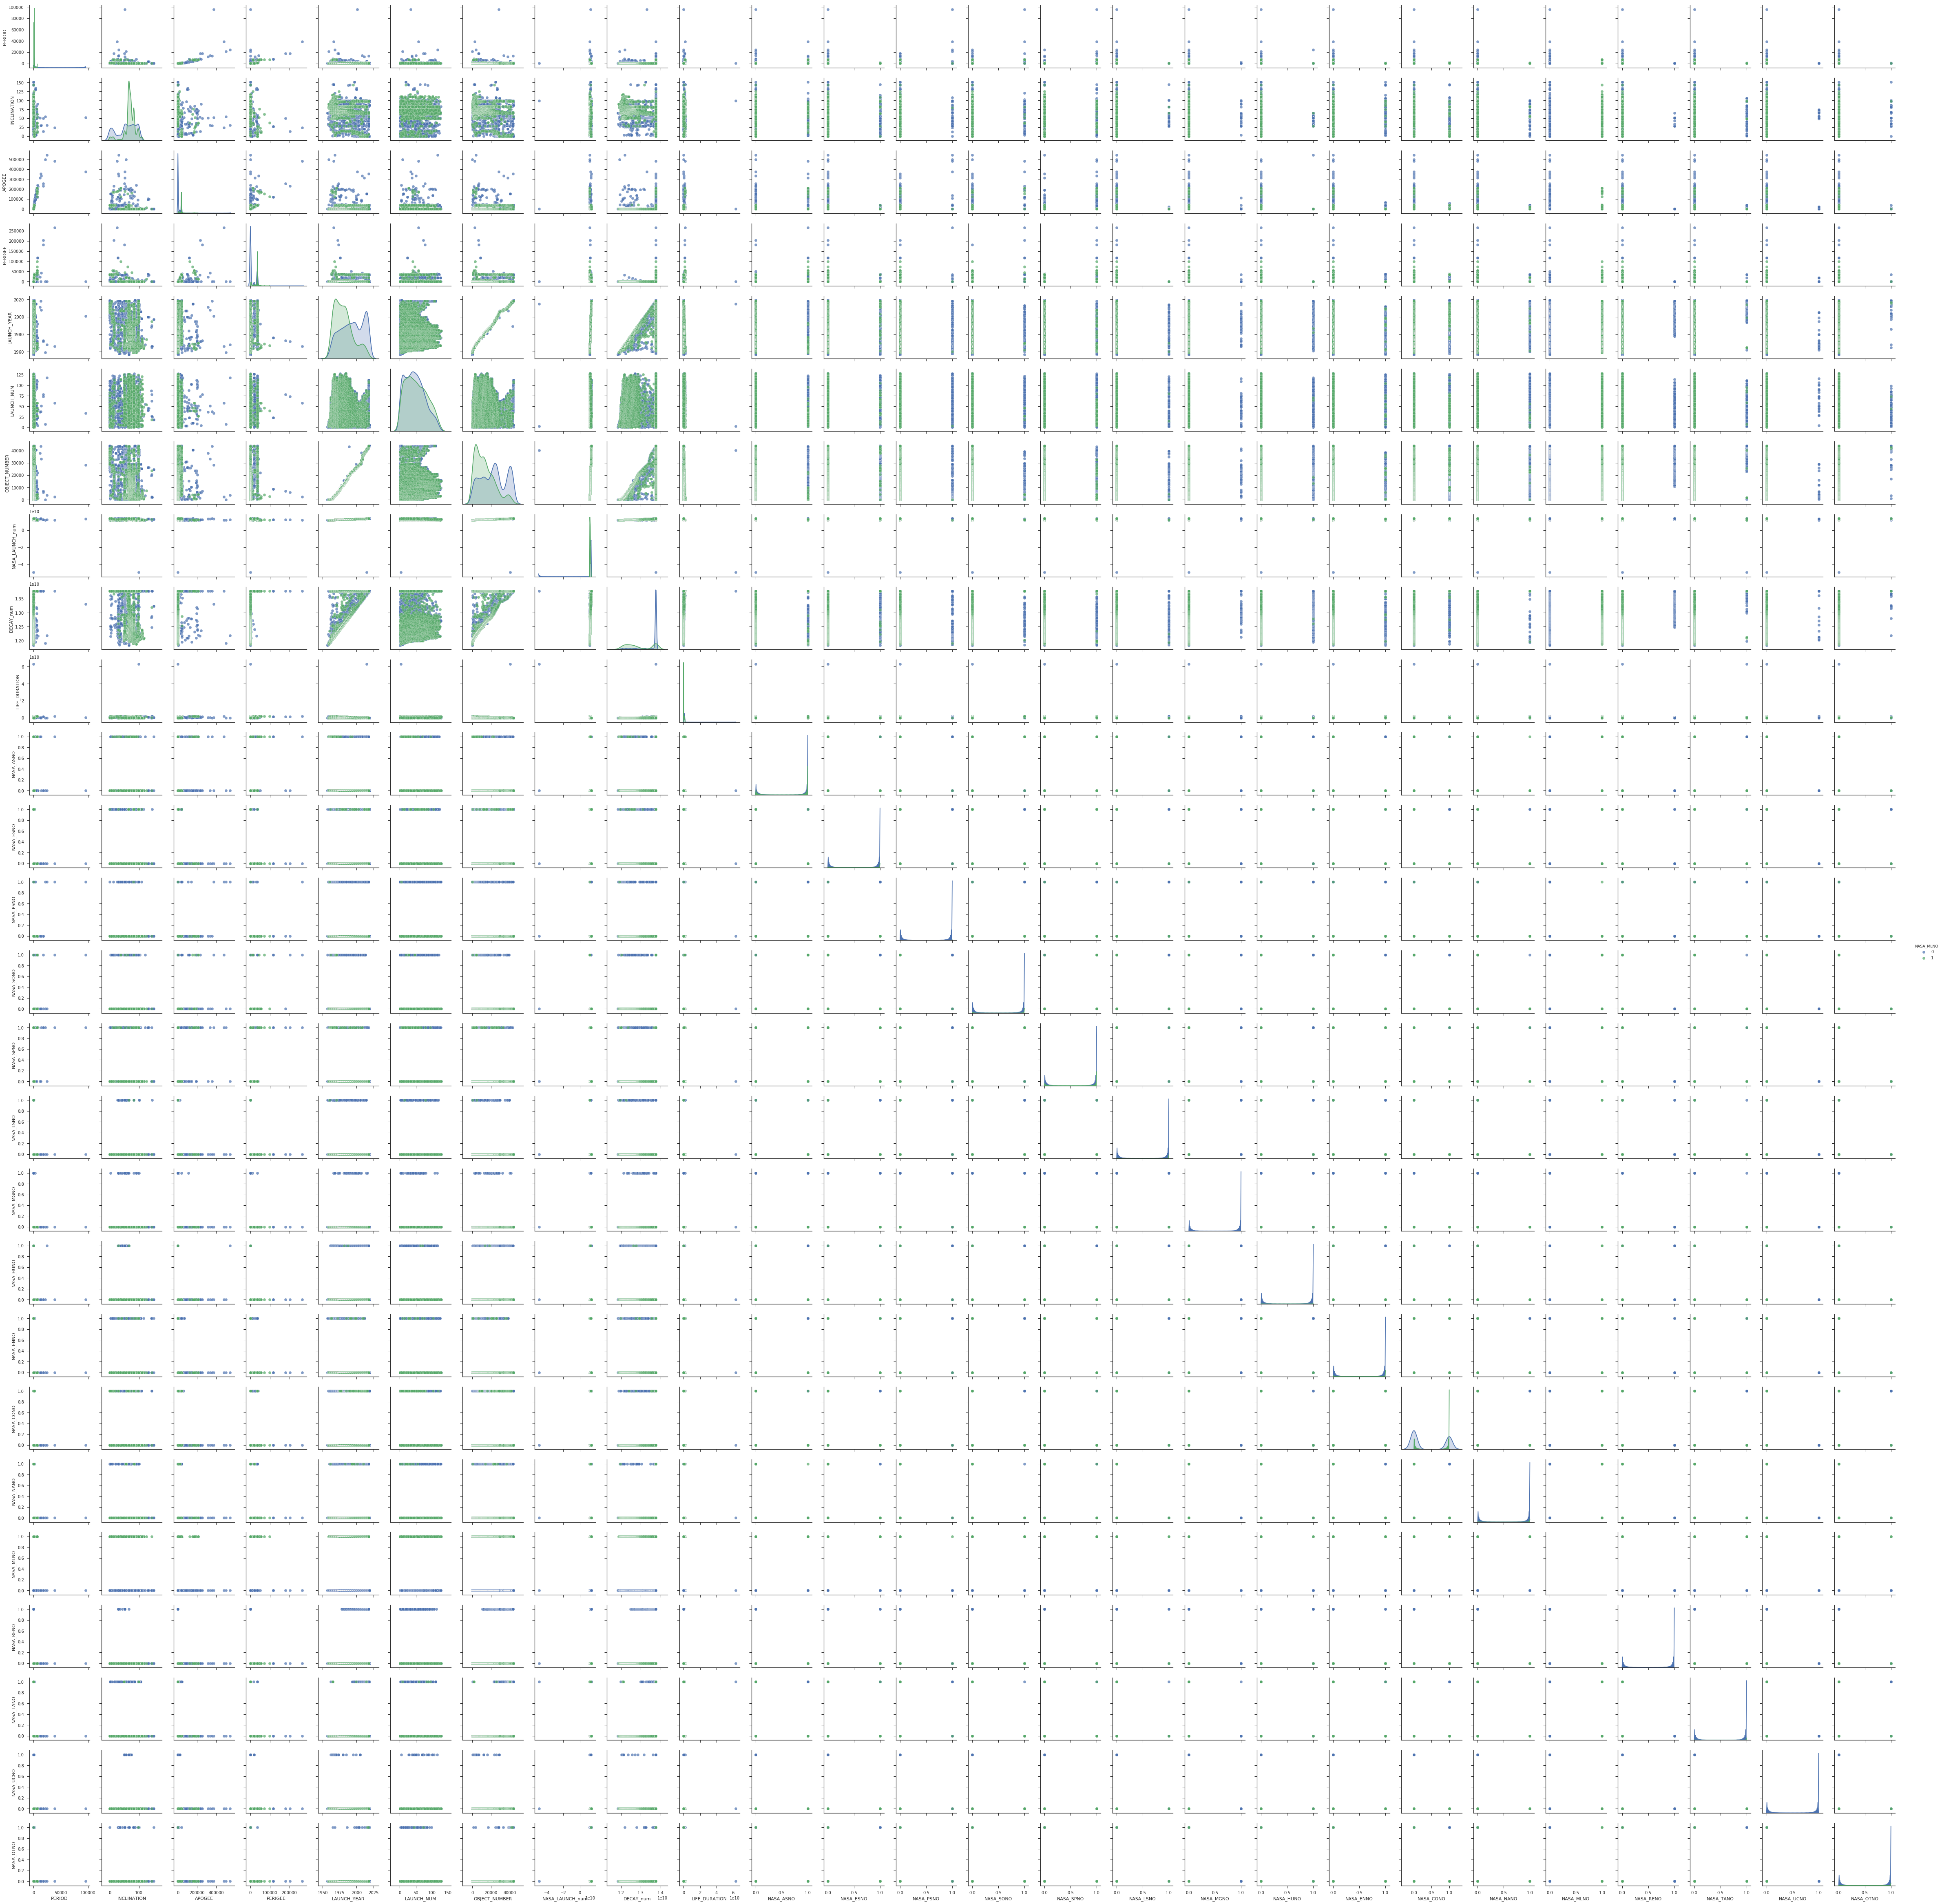

In [34]:
import seaborn as sns
sns.set(style="ticks", color_codes=True);
# Create a custom color palete
# Make the pair plot with a some aesthetic changes
sns.pairplot(csats[numerical_features], hue = 'NASA_MLNO', diag_kind = 'kde', plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(shade=True))

In [35]:
csats.shape

(7677, 45)

# Model

In [36]:
relevant_features = numerical_features + ["COUNTRY", "SITE", "LAUNCH_PIECE", "CURRENT"]  # will be converted to One-hot encoding by get_dummies

In [37]:
# One Hot Encoding of categorical features
featuresDF = pd.get_dummies(csats[relevant_features].dropna(how="any"))
print(featuresDF.columns)
featuresDF.head(10)

Index(['PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE', 'LAUNCH_YEAR',
       'LAUNCH_NUM', 'OBJECT_NUMBER', 'NASA_LAUNCH_num', 'DECAY_num',
       'LIFE_DURATION',
       ...
       'LAUNCH_PIECE_R', 'LAUNCH_PIECE_S', 'LAUNCH_PIECE_T', 'LAUNCH_PIECE_U',
       'LAUNCH_PIECE_V', 'LAUNCH_PIECE_W', 'LAUNCH_PIECE_X', 'LAUNCH_PIECE_Y',
       'LAUNCH_PIECE_Z', 'CURRENT_Y'],
      dtype='object', length=174)


PERIOD  INCLINATION  APOGEE  PERIGEE  LAUNCH_YEAR  LAUNCH_NUM  \
INTLDES                                                                    
1957-001A   96.19        65.10   938.0    214.0         1957           1   
1957-001B   96.10        65.00   945.0    227.0         1957           1   
1957-002A  103.74        65.33  1659.0    211.0         1957           2   
1958-001A   88.48        33.15   215.0    183.0         1958           1   
1958-002B  132.74        34.26  3834.0    650.0         1958           2   
1958-003A  103.60        33.50  1739.0    117.0         1958           3   
1958-004B   88.43        65.06   255.0    139.0         1958           4   
1958-005A   92.81        50.25   585.0    239.0         1958           5   
1958-006A   98.21        32.29  1187.0    159.0         1958           6   
1959-001A  121.46        32.88  2940.0    552.0         1959           1   

           OBJECT_NUMBER  NASA_LAUNCH_num    DECAY_num  LIFE_DURATION  \
INTLDES                                                                 
1957-001A              1      11832912000  11837923200        5011200   
1957-001B              2      11832912000  11840774400        7862400   
1957-002A              3      11835504000  11849500800       13996800   
1958-001A              4      11843280000  12226982400      383702400   
1958-002B              5      11847081600  13769886046     1922804446   
1958-003A              6      11847859200  11855980800        8121600   
1958-004B              8      11852179200  11911968000       59788800   
1958-005A              9      11858400000  11897625600       39225600   
1958-006A             10      11870928000  11873865600        2937600   
1959-001A             11      11876198400  13769886046     1893687646   

             ...      LAUNCH_PIECE_R  LAUNCH_PIECE_S  LAUNCH_PIECE_T  \
INTLDES      ...                                                       
1957-001A    ...                   0               0               0   
1957-001B    ...                   0               0               0   
1957-002A    ...                   0               0               0   
1958-001A    ...                   0               0               0   
1958-002B    ...                   0               0               0   
1958-003A    ...                   0               0               0   
1958-004B    ...                   0               0               0   
1958-005A    ...                   0               0               0   
1958-006A    ...                   0               0               0   
1959-001A    ...                   0               0               0   

           LAUNCH_PIECE_U  LAUNCH_PIECE_V  LAUNCH_PIECE_W  LAUNCH_PIECE_X  \
INTLDES                                                                     
1957-001A               0               0               0               0   
1957-001B               0               0               0               0   
1957-002A               0               0               0               0   
1958-001A               0               0               0               0   
1958-002B               0               0               0               0   
1958-003A               0               0               0               0   
1958-004B               0               0               0               0   
1958-005A               0               0               0               0   
1958-006A               0               0               0               0   
1959-001A               0               0               0               0   

           LAUNCH_PIECE_Y  LAUNCH_PIECE_Z  CURRENT_Y  
INTLDES                                               
1957-001A               0               0          1  
1957-001B               0               0          1  
1957-002A               0               0          1  
1958-001A               0               0          1  
1958-002B               0               0          1  
1958-003A               0               0     

In [38]:
# Label / Train-test
# Extract features and labels
labels = featuresDF['NASA_MLNO']
featuresDF = featuresDF.drop('NASA_MLNO', axis = 1)
# List of features for later use
feature_list = list(featuresDF.columns)
# Convert to numpy arrays
features = np.array(featuresDF)
labels = np.array(labels)
# Training and Testing Sets
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (5339, 173)
Training Labels Shape: (5339,)
Testing Features Shape: (1780, 173)
Testing Labels Shape: (1780,)


In [39]:
# Instantiate random forest and train on new features
from sklearn.ensemble import RandomForestClassifier
rf_exp = RandomForestClassifier(n_estimators= 1000, random_state=100, verbose=3)
rf_exp.fit(train_features, train_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=100, verbose=3, warm_start=False)

In [40]:
def accuracy_helper(model, features, labels):
    predictions = model.predict(features)
    errors = abs(predictions - labels)
    return 100 - 100 * np.mean(errors)

def accuracy(model):
    global train_features, train_labels, test_features, test_labels
    print('Train accuracy:', round(accuracy_helper(model, train_features, train_labels), 2), '%.')
    print('Test accuracy:', round(accuracy_helper(model, test_features, test_labels), 2), '%.')

In [41]:
accuracy(rf_exp)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Train accuracy: 100.0 %.
Test accuracy: 96.52 %.


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [42]:
# FEATURES IMPORTANCE

# Get numerical feature importances
importances = list(rf_exp.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
from pprint import pprint
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
pprint(feature_importances[:20])

[('PERIOD', 0.0967),
 ('PERIGEE', 0.0877),
 ('INCLINATION', 0.0828),
 ('APOGEE', 0.0811),
 ('DECAY_num', 0.0756),
 ('LIFE_DURATION', 0.0731),
 ('OBJECT_NUMBER', 0.0574),
 ('NASA_LAUNCH_num', 0.055),
 ('NASA_CONO', 0.0533),
 ('NASA_ESNO', 0.0495),
 ('LAUNCH_YEAR', 0.0447),
 ('LAUNCH_NUM', 0.0244),
 ('COUNTRY_CIS', 0.0236),
 ('NASA_SPNO', 0.0221),
 ('NASA_NANO', 0.0178),
 ('SITE_PKMTR', 0.0167),
 ('NASA_ENNO', 0.0158),
 ('LAUNCH_PIECE_A', 0.0149),
 ('NASA_HUNO', 0.0139),
 ('SITE_AFETR', 0.0103)]


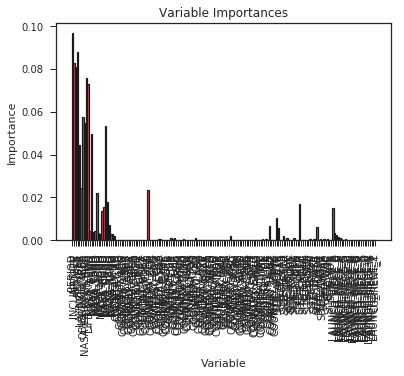

In [43]:
# Plot features importance
import matplotlib.pyplot as plt
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.show()

In [44]:
# RANDOM SEARCH WITH CROSS VALIDATION
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 30)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 25, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16, 32]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 4, 6, 8, 11, 13, 15, 18, 20, 22, 25, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 16, 32],
 'min_samples_split': [2, 5, 10, 20, 30, 50],
 'n_estimators': [10,
                  26,
                  43,
                  60,
                  77,
                  94,
                  111,
                  128,
                  145,
                  162,
                  178,
                  195,
                  212,
                  229,
                  246,
                  263,
                  280,
                  297,
                  314,
                  331,
                  347,
                  364,
                  381,
                  398,
                  415,
                  432,
                  449,
                  466,
                  483,
                  500]}


In [45]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   45.5s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [10, 26, 43, 60, 77, 94, 111, 128, 145, 162, 178, 195, 212, 229, 246, 263, 280, 297, 314, 331, 347, 364, 381, 398, 415, 432, 449, 466, 483, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4, 6, 8, 11, 13, 15, 18, 20, 22, 25, None], 'min_samples_split': [2, 5, 10, 20, 30, 50], 'min_samples_leaf': [1, 2, 4, 8, 16, 32], 'bootstrap': [True, False]},
          pre_dispatch='2*n_

In [46]:
accuracy(rf_random)

Train accuracy: 99.72 %.
Test accuracy: 96.29 %.
